# Inequalities in London Pedestrian Safety (2019-2023)

## Preparation

- [Github link](https://github.com/Aprilmiaoyilee/casa0006_report)

- Number of words: 1467

- Runtime: 2.05 minutes (*Memory 32 GB, i7-9750H CPU @ 2.60GHz*)

- Coding environment: SDS Docker (or anything else)

- License: this notebook is made available under the [Creative Commons Attribution license](https://creativecommons.org/licenses/by/4.0/) (or other license that you like).

- Additional library *[libraries not included in SDS Docker or not used in this module]*:
    - **watermark**: A Jupyter Notebook extension for printing timestamps, version numbers, and hardware information.
    - **KModes**: A Python library for clustering categorical data using the k-modes algorithm.

In [1]:
!pip install kmodes
!pip install watermark

In [2]:
%load_ext watermark
%watermark --machine

Compiler    : GCC 12.3.0
OS          : Linux
Release     : 5.15.167.4-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 12
Architecture: 64bit



In [3]:
import time
notebook_start_time = time.time()
# Record and display the notebook start time
print("Notebook execution started at:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

Notebook execution started at: 2025-04-22 00:57:42


In [4]:
# Packages for data manipulation and processing
import pandas as pd
import numpy as np
import os

# Packages for statistical analysis and machine learning
from scipy.stats import ttest_ind
from sklearn.linear_model import LogisticRegression
from kmodes.kmodes import KModes

# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns


## Table of contents

1. [Introduction](#Introduction)

1. [Research questions](#Research-questions)

1. [Methodology](#Methodology)

1. [Data Wrangling and Analysis](#Data-Wrangling-and-Analysis)

1. [Discussion](#Discussion)

1. [Conclusion](#Conclusion)

1. [References](#References)

## Introduction

[[ go back to the top ]](#Table-of-contents)

In London, pedestrian safety is both a transport and equity issue. While traffic fatalities have declined in other travel modes as outlined in the Vision Zero action plan (Transport for London, 2018), pedestrians remain disproportionately affected, particularly in socioeconomically deprived regions (Transport for London, 2023).

The Index of Multiple Deprivation (IMD) offers a granular picture of LSOA-based disadvantage, which allows previous studies to show strong associations between deprivation and pedestrian casualties (Feleke et al., 2018). However, a causal relationship between them requires more exploration.

Also, most studies relevant to this relationship focus on the influence of area deprivation on casualties (Graham et al., 2005), giving little advice for local authorities to target interventions on road safety. So, more attention should be given to the analysis of road crash patterns of casualties living in deprived areas, such as detecting crash clusters with infrastructural and environmental characteristics (Bonera et al., 2022). Thus, specific solutions can be suggested to mitigate pedestrian crash occurrences.

Based on the significance of pedestrian safety and its inequalities above, research questions are posed as follows to investigate the causation and patterns from a deprivation scope.



## Research questions

[[ go back to the top ]](#Table-of-contents)


- **Q1**: Does living in more deprived LSOAs contribute to higher pedestrian casualty rates in London?
- **Q2**: What distinct patterns of pedestrian casualties can be identified with varying levels of deprivation in London?

## Methodology

[[ go back to the top ]](#Table-of-contents)

1. To assess whether deprivation causally impacts pedestrian casualty rates, **Propensity Score Matching (PSM)** is used on observational road safety data (Szubelak, 2024). Since the road safety data is observational rather than from a randomized experiment, PSM helps reduce bias by making treated and untreated groups comparable. First, logistic regression estimates the probability of an LSOA being deprived based on confounders (e.g. sex, accessibility). Next, nearest-neighbour matching finds comparable groups. After matching, balance checks confirm similarity, allowing for the average treatment effect on the treated (ATT), isolating deprivation's impact on casualty rates.

2.To identify deprivation-specific crash patterns, individual casualty records are analysed with a two-stage **K-modes** clustering procedure. First, the dataset is divided into a low IMD subset (deciles = 1, 2, 3) and a high IMD subset (rest deciles). Within each subset, categorical risk factors are clustered using K-modes and the optimal number of clusters was chosen by the elbow criterion on the cost curve. Each cluster's modal categories and case count formed a profile. Two cluster profiles can then be compared to show differences in crash circumstances associated with deprivation.

3. Both analyses use the LSOA level IMD decile to measure deprivation.



Figure 1 Flowchart | Source: Author ![](https://github.com/Aprilmiaoyilee/casa0006_report/blob/main/figure/flowchart_revised.png?raw=true)


## Data Wrangling and Analysis

[[ go back to the top ]](#Table-of-contents)

As variables used in PSM and K-modes differ, the data wrangling process is divided into two parts. But the raw data is the same, composed of [merged road safety data(2019-2023)](https://www.data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-accidents-safety-data)and [PTAL 2015 data](https://data.london.gov.uk/dataset/public-transport-accessibility-levels).

In [5]:
base_path = 'https://raw.githubusercontent.com/Aprilmiaoyilee/casa0006_report/main/Data/'

# Function to merge road safety data
def merge_road_safety_data(base_path, years):
    """
    Merge road safety casualty and collision data across multiple years with explicit dtype handling.
        base_path (str): Base directory path containing the CSV files
        years (list): List of years to process
    """
    # Store yearly merged DataFrames
    merged_data_list = []

    for year in years:
        # Construct file names
        casualty_file = f"dft-road-casualty-statistics-casualty-{year}.csv"
        collision_file = f"dft-road-casualty-statistics-collision-{year}.csv"

        # Read datasets with explicit dtype for columns 0 and 2(accident_index)
        # to avoid dtype warnings and ensure consistent data types
        casualty_df = pd.read_csv(
            os.path.join(base_path, casualty_file),
            dtype={0: str, 2: str},
            low_memory=False  # Disable low memory warnings
        )

        collision_df = pd.read_csv(
            os.path.join(base_path, collision_file),
            dtype={0: str, 2: str},
            low_memory=False
        )

        # Deduplicate collision data to ensure one row per unique accident_index
        collision_df_deduped = collision_df.drop_duplicates(subset=['accident_index'])

        # Merge datasets using left join to keep all casualty records
        merged_df = casualty_df.merge(
            collision_df_deduped,
            on='accident_index',
            how='left',
            suffixes=('_casualty', '_collision')
        )

        # Add a 'year' column for traceability
        merged_df['year'] = year

        # Append to the list
        merged_data_list.append(merged_df)

    # Concatenate all years into one DataFrame
    final_df = pd.concat(merged_data_list, ignore_index=True)

    return final_df

# Set year from 2019-2023
years = list(range(2019, 2024))

# Merge the data
merged_road_safety_data = merge_road_safety_data(base_path, years)

In [6]:
merged_road_safety_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 665408 entries, 0 to 665407
Data columns (total 58 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   accident_index                               665408 non-null  object 
 1   accident_year_casualty                       665408 non-null  int64  
 2   accident_reference_casualty                  665408 non-null  object 
 3   vehicle_reference                            665408 non-null  int64  
 4   casualty_reference                           665408 non-null  int64  
 5   casualty_class                               665408 non-null  int64  
 6   sex_of_casualty                              665408 non-null  int64  
 7   age_of_casualty                              665408 non-null  int64  
 8   age_band_of_casualty                         665408 non-null  int64  
 9   casualty_severity                            665408 non-nul

Here we choose relevant columns in raw dataset based on three principles:
1. For PSM, choose columns that can influence both deprivation and casualty rate.
2. For K-modes, choose categorical variables that can be used for to depict the casualty patterns related to infrastructure and environment for possible intervention suggestions.
3. For both, choose basic geodemographic data.

In [7]:
# Select relevant columns for analysis
relative_col = ['accident_year_casualty', 'accident_severity', 'sex_of_casualty', 'age_of_casualty', 'age_band_of_casualty','casualty_severity', 'pedestrian_location', 'casualty_type','casualty_imd_decile','lsoa_of_casualty','road_surface_conditions', 'light_conditions', 'time', 'pedestrian_crossing_physical_facilities']

In [8]:
# Filter for pedestrian casualties (casualty_type == 0)
pedestrian_data = merged_road_safety_data[merged_road_safety_data['casualty_type'] == 0][relative_col]

In [9]:
pedestrian_data.head(10)

,accident_year_casualty,accident_severity,sex_of_casualty,age_of_casualty,age_band_of_casualty,casualty_severity,pedestrian_location,casualty_type,casualty_imd_decile,lsoa_of_casualty,road_surface_conditions,light_conditions,time,pedestrian_crossing_physical_facilities
5,2019,2,1,68,10,2,5,0,4,E01000965,1,4,01:20,0
11,2019,3,1,40,7,3,1,0,4,E01001179,1,4,01:35,5
19,2019,3,1,23,5,3,1,0,8,E01002478,1,4,01:15,4
20,2019,1,1,24,5,1,5,0,10,E01022664,1,6,03:00,0
21,2019,3,1,38,7,3,5,0,4,E01002775,1,4,02:45,4
22,2019,2,1,37,7,2,1,0,1,-1,1,4,04:10,5
24,2019,2,1,22,5,2,10,0,2,E01004296,1,4,05:55,0
26,2019,3,1,47,8,3,9,0,2,E01001331,1,7,02:45,0
31,2019,3,1,27,6,3,1,0,10,E01014987,1,1,15:20,4
41,2019,3,1,33,6,3,6,0,8,E01004506,1,1,12:00,0


In [10]:
# Drop the columns without lsoa information as we need to find data in GLA
pedestrian_data['lsoa_of_casualty'] = pedestrian_data['lsoa_of_casualty'].astype(str)
pedestrian_data = pedestrian_data[pedestrian_data['lsoa_of_casualty'] != "-1"]

In [11]:
# Check the version of lsoa code is 2011 or 2021 for data in 2022 and 2023
lsoacode11 = pd.read_csv(f"{base_path}/LSOA_(2011)_to_LSOA_(2021)_to_Local_Authority_District_(2022)_Exact_Fit_Lookup_for_EW_(V3).csv")
lsoacode11.head()

,LSOA11CD,LSOA11NM,LSOA21CD,LSOA21NM,CHGIND,LAD22CD,LAD22NM,LAD22NMW,ObjectId
0,E01031349,Adur 001A,E01031349,Adur 001A,U,E07000223,Adur,NaN,1
1,E01031350,Adur 001B,E01031350,Adur 001B,U,E07000223,Adur,NaN,2
2,E01031351,Adur 001C,E01031351,Adur 001C,U,E07000223,Adur,NaN,3
3,E01031352,Adur 001D,E01031352,Adur 001D,U,E07000223,Adur,NaN,4
4,E01031370,Adur 001E,E01031370,Adur 001E,U,E07000223,Adur,NaN,5


In [12]:
# Filter records where accident_year_casualty need lsoa code matching
pedestrian_data_2022_2023 = pedestrian_data[pedestrian_data['accident_year_casualty'].isin([2022, 2023])].copy()

# Merge with lsoacode11 to find matching LSOA codes
merged_data = pedestrian_data_2022_2023.merge(
    lsoacode11[['LSOA21CD', 'LSOA11CD']],
    left_on='lsoa_of_casualty',
    right_on='LSOA11CD',
    how='left'
)

merged_data_null_values = merged_data.isnull().sum()
# Check the number of null values in each column
print(merged_data_null_values)
# Currently, using LSOA21CD to match lsoacode in dataset will get null
# While using LSOA11CD will not as below
# So even in 2022 and 2023, TfL were still using LSOA11CD for all records

accident_year_casualty                     0
accident_severity                          0
sex_of_casualty                            0
age_of_casualty                            0
age_band_of_casualty                       0
casualty_severity                          0
pedestrian_location                        0
casualty_type                              0
casualty_imd_decile                        0
lsoa_of_casualty                           0
road_surface_conditions                    0
light_conditions                           0
time                                       0
pedestrian_crossing_physical_facilities    0
LSOA21CD                                   0
LSOA11CD                                   0
dtype: int64


In [13]:
# Filter out data in London using LADcode starting with 'E09'
# Merge LAD22CD from lsoacode11 into pedestrian_data
pedestrian_data = pedestrian_data.merge(
    lsoacode11[['LSOA11CD', 'LAD22CD']],
    left_on='lsoa_of_casualty',
    right_on='LSOA11CD',
    how='left'
)
pedestrian_data = pedestrian_data[pedestrian_data['LAD22CD'].str.startswith('E09', na=False)]

In [14]:
pedestrian_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21015 entries, 0 to 80245
Data columns (total 16 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   accident_year_casualty                   21015 non-null  int64 
 1   accident_severity                        21015 non-null  int64 
 2   sex_of_casualty                          21015 non-null  int64 
 3   age_of_casualty                          21015 non-null  int64 
 4   age_band_of_casualty                     21015 non-null  int64 
 5   casualty_severity                        21015 non-null  int64 
 6   pedestrian_location                      21015 non-null  int64 
 7   casualty_type                            21015 non-null  int64 
 8   casualty_imd_decile                      21015 non-null  int64 
 9   lsoa_of_casualty                         21015 non-null  object
 10  road_surface_conditions                  21015 non-null  int64 

In [15]:
# Add Public Transport Access Level (PTAL) data
public_transport_access_level = pd.read_csv(f"{base_path}/LSOA2011_AvPTAI2015.csv")
public_transport_access_level.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   LSOA2011    4835 non-null   object 
 1   AvPTAI2015  4835 non-null   float64
 2   PTAL        4835 non-null   object 
 3   PTAIHigh    4835 non-null   float64
 4   PTAILow     4835 non-null   float64
dtypes: float64(3), object(2)
memory usage: 189.0+ KB


In [16]:
public_transport_access_level.head()

,LSOA2011,AvPTAI2015,PTAL,PTAIHigh,PTAILow
0,E01000001,69.8233,6b,97.4435,35.9190
1,E01000002,83.7820,6b,117.9120,66.3503
2,E01000003,41.7417,6b,49.5318,37.3635
3,E01000005,85.8893,6b,120.8470,45.9168
4,E01000006,22.4558,5,34.1054,0.0000


In [17]:
# Merge average PTAI data and PTAL data with pedestrian_data
pedestrian_data = pedestrian_data.merge(
    public_transport_access_level[['LSOA2011', 'AvPTAI2015', 'PTAL']],
    left_on='lsoa_of_casualty',
    right_on='LSOA2011',
    how='left'
)
# Drop the LSOA2011 column after merging as we have one
pedestrian_data.drop(columns=['LSOA2011'], inplace=True)

In [18]:
# # Define the function to classify time into time_of_day
def time_of_day(hour, minute):
    if (hour == 6 and minute >= 30) or (7 <= hour < 9) or (hour == 9 and minute < 30):
        return 'Morning Peak'
    elif 9 <= hour < 16:
        return 'Daytime'
    elif 16 <= hour < 19:
        return 'Evening Peak'
    else:
        return 'Night'

# Ensure the time column is in the correct format
pedestrian_data['time'] = pd.to_datetime(pedestrian_data['time'], format='%H:%M', errors='coerce')

# Extract hour and minute and apply the function
pedestrian_data['time_of_day'] = pedestrian_data['time'].apply(
    lambda x: time_of_day(x.hour, x.minute) if pd.notnull(x) else None
)

pedestrian_data['time'] = pedestrian_data['time'].dt.strftime('%H:%M')

pedestrian_data.head()

,accident_year_casualty,accident_severity,sex_of_casualty,age_of_casualty,age_band_of_casualty,casualty_severity,pedestrian_location,casualty_type,casualty_imd_decile,lsoa_of_casualty,road_surface_conditions,light_conditions,time,pedestrian_crossing_physical_facilities,LSOA11CD,LAD22CD,AvPTAI2015,PTAL,time_of_day
0,2019,2,1,68,10,2,5,0,4,E01000965,1,4,01:20,0,E01000965,E09000007,26.53350,6a,Night
1,2019,3,1,40,7,3,1,0,4,E01001179,1,4,01:35,5,E01001179,E09000008,6.14915,2,Night
2,2019,3,1,23,5,3,1,0,8,E01002478,1,4,01:15,4,E01002478,E09000017,8.95702,2,Night
3,2019,3,1,38,7,3,5,0,4,E01002775,1,4,02:45,4,E01002775,E09000019,29.98690,6a,Night
4,2019,2,1,22,5,2,10,0,2,E01004296,1,4,05:55,0,E01004296,E09000030,18.80660,4,Night


In [19]:
# Check basic missing values as many null values presented as '-1' or '9' in the dataset
# And two analysis use different columns, so we address them separately
pedestrian_data_null_values = pedestrian_data.isnull().sum()
# Check the number of null values in each column
print(pedestrian_data_null_values)

accident_year_casualty                     0
accident_severity                          0
sex_of_casualty                            0
age_of_casualty                            0
age_band_of_casualty                       0
casualty_severity                          0
pedestrian_location                        0
casualty_type                              0
casualty_imd_decile                        0
lsoa_of_casualty                           0
road_surface_conditions                    0
light_conditions                           0
time                                       0
pedestrian_crossing_physical_facilities    0
LSOA11CD                                   0
LAD22CD                                    0
AvPTAI2015                                 0
PTAL                                       0
time_of_day                                0
dtype: int64


Some columns can be expressed in two ways — as exact numbers or as grouped categories. Categorical variables are kept for K-modes clustering to catch clear, human‑readable cluster qroups. Such as ages band instead of certain ages can be easily linked to labels like “young adults” to make the resulting clusters easier to discuss.

### Propensity Score Matching(PSM)

[[ go back to the top ]](#Table-of-contents)

PSM needs three types of variables:
1. **Outcome Variable (Effect)** ： Pedestrian Casualty Rate which will be calculated per 1000 population in each LSOA.

2. **Treatment Variable (Cause)**: Living in LSOAs of IMD deciles lower than or equal to 3; otherwise, they are “untreated".

3. **Confounding Variables (Covariates)** ： Factors that influence both deprivation and casualty rate, and so some bias can persist as potential confounders such as infrastructure quality were omitted.



Figure 2 Casual Diagram for PSM Variables | Source: [Zolzaya Luvsandorj](https://builtin.com/data-science/propensity-score-matching)

![Source](https://builtin.com/sites/www.builtin.com/files/styles/ckeditor_optimize/public/inline-images/1_propensity-score-matching.jpeg)

#### Datasets

In [20]:
PSM_data = pedestrian_data[['sex_of_casualty','age_of_casualty', 'casualty_imd_decile', 'lsoa_of_casualty', 'AvPTAI2015']].copy()

In [21]:
PSM_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21015 entries, 0 to 21014
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sex_of_casualty      21015 non-null  int64  
 1   age_of_casualty      21015 non-null  int64  
 2   casualty_imd_decile  21015 non-null  int64  
 3   lsoa_of_casualty     21015 non-null  object 
 4   AvPTAI2015           21015 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 821.0+ KB


After choosing the variables satisfying PSM needs, we convert data to LSOA level to start PSM as casualty rate cannot be calculated at individual level. Only sex and age data need this conversion, as the rest are already at LSOA level.

In [22]:
# search missing values in sex and age columns
# PTAI and lsoa missing value handled in the previous step but check again
# -1 or 9 represents missing value in age_of_casualty
# -1 represents missing value in sex_of_casualty

sex_missing = PSM_data[PSM_data['sex_of_casualty'] == -1].shape[0]
sex_missing_pct = (sex_missing / len(PSM_data)) * 100

age_missing = PSM_data[(PSM_data['age_of_casualty'] == -1) | (PSM_data['age_of_casualty'] == 9)].shape[0]
age_missing_pct = (age_missing / len(PSM_data)) * 100

ptai_missing = PSM_data['AvPTAI2015'].isnull().sum()
ptai_missing_pct = (ptai_missing / len(PSM_data)) * 100

lsoa_missing = PSM_data['lsoa_of_casualty'].isnull().sum()
lsoa_missing_pct = (lsoa_missing / len(PSM_data)) * 100

print(f"Sex missing values: {sex_missing} ({sex_missing_pct:.2f}%)")
print(f"Age missing values: {age_missing} ({age_missing_pct:.2f}%)")
print(f"PTAI missing values: {ptai_missing} ({ptai_missing_pct:.2f}%)")
print(f"LSOA missing values: {lsoa_missing} ({lsoa_missing_pct:.2f}%)")

Sex missing values: 128 (0.61%)
Age missing values: 443 (2.11%)
PTAI missing values: 0 (0.00%)
LSOA missing values: 0 (0.00%)


In [23]:
# Drop missing Sex and age values as they do not make up a large percentage of the data
# Drop rows where sex is -1 or age is -1/9
PSM_data = PSM_data[
    (PSM_data['sex_of_casualty'] != -1) &
    ~((PSM_data['age_of_casualty'] == -1) | (PSM_data['age_of_casualty'] == 9))
]

PSM_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20460 entries, 0 to 21014
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sex_of_casualty      20460 non-null  int64  
 1   age_of_casualty      20460 non-null  int64  
 2   casualty_imd_decile  20460 non-null  int64  
 3   lsoa_of_casualty     20460 non-null  object 
 4   AvPTAI2015           20460 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 959.1+ KB


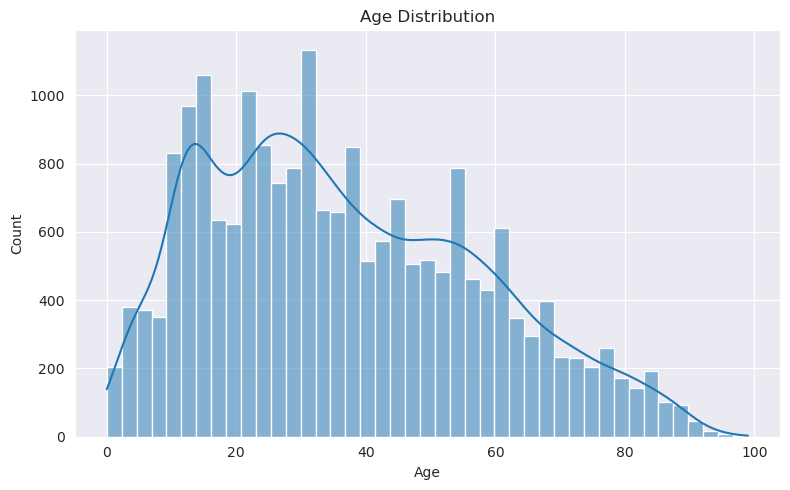


Descriptive Statistics:
count    20460.000000
mean        36.618964
std         21.133750
min          0.000000
25%         20.000000
50%         33.000000
75%         52.000000
max         99.000000
Name: age_of_casualty, dtype: float64


In [24]:
# Create single plot
plt.figure(figsize=(8, 5))

# Histogram with KDE
sns.histplot(data=PSM_data, x='age_of_casualty', kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Print basic statistics
print("\nDescriptive Statistics:")
print(PSM_data['age_of_casualty'].describe())

The whole age distribution is skewed, so when aggregating age to LSOA level, we use median().

In [25]:
PSM_lsoa = PSM_data.groupby('lsoa_of_casualty').agg(
    casualty_total=('sex_of_casualty', 'count'),
    age_median=('age_of_casualty', 'median'),
    male_count=('sex_of_casualty', lambda x: (x == 1).sum()),
    female_count=('sex_of_casualty', lambda x: (x == 2).sum())
).reset_index()

# Calculate gender ratios
PSM_lsoa['male_ratio'] = PSM_lsoa['male_count'] / PSM_lsoa['casualty_total']
PSM_lsoa['female_ratio'] = PSM_lsoa['female_count'] / PSM_lsoa['casualty_total']

# # Round ratios to 3 decimal places
# PSM_lsoa = PSM_lsoa.round({'male_ratio': 3, 'female_ratio': 3})

# Display first few rows and basic info
print("First few rows:")
print(PSM_lsoa.head())
print("\nDataset Info:")
print(PSM_lsoa.info())

First few rows:
  lsoa_of_casualty  casualty_total  age_median  male_count  female_count  \
0        E01000001               1        40.0           0             1   
1        E01000002               1        74.0           1             0   
2        E01000003               5        58.0           1             4   
3        E01000005               2        30.5           1             1   
4        E01000006               7        27.0           5             2   

   male_ratio  female_ratio  
0    0.000000      1.000000  
1    1.000000      0.000000  
2    0.200000      0.800000  
3    0.500000      0.500000  
4    0.714286      0.285714  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4596 entries, 0 to 4595
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lsoa_of_casualty  4596 non-null   object 
 1   casualty_total    4596 non-null   int64  
 2   age_median        4596 non-null  

Sample in each LSOA is quite small, so the PSM model may not be very effective. Below we introducw LSOA population data to calculate casualty rate per 1000 population.

In [26]:
lsoapop = pd.read_csv(f"{base_path}/lsoapop.csv")
lsoapop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   lsoacode_2011  4835 non-null   object
 1   totalpop_2015  4835 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 75.7+ KB


In [27]:
# Merge lsoa population data to calculate casualty rate
PSM_lsoa = PSM_lsoa.merge(
    lsoapop[['lsoacode_2011', 'totalpop_2015']],
    left_on='lsoa_of_casualty',
    right_on='lsoacode_2011',
    how='left'
).drop('lsoacode_2011', axis=1)

# Calculate casualty rate per 1000 population
PSM_lsoa['casualty_rate_per_1000'] = (PSM_lsoa['casualty_total'] / PSM_lsoa['totalpop_2015']) * 1000
# Merge IMD and PTAI data
PSM_lsoa = PSM_lsoa.merge(
    PSM_data[['lsoa_of_casualty', 'casualty_imd_decile', 'AvPTAI2015']].drop_duplicates(),
    on='lsoa_of_casualty',
    how='left'
)[PSM_lsoa.columns.tolist() + ['casualty_imd_decile', 'AvPTAI2015']]
# Assign treatment variable based on IMD decile
PSM_lsoa['treat'] = (PSM_lsoa['casualty_imd_decile'] <= 3).astype(int)

In [28]:
PSM_lsoa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4596 entries, 0 to 4595
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   lsoa_of_casualty        4596 non-null   object 
 1   casualty_total          4596 non-null   int64  
 2   age_median              4596 non-null   float64
 3   male_count              4596 non-null   int64  
 4   female_count            4596 non-null   int64  
 5   male_ratio              4596 non-null   float64
 6   female_ratio            4596 non-null   float64
 7   totalpop_2015           4596 non-null   int64  
 8   casualty_rate_per_1000  4596 non-null   float64
 9   casualty_imd_decile     4596 non-null   int64  
 10  AvPTAI2015              4596 non-null   float64
 11  treat                   4596 non-null   int64  
dtypes: float64(5), int64(6), object(1)
memory usage: 431.0+ KB


Table 1 Variables for PSM

| Variable               | Type        | Description                                                                                   | Notes                |
|------------------------|-------------|-----------------------------------------------------------------------------------------------|----------------------|
| casualty_rate_per_1000 | Numeric     | The pedestrian casualty rate per 1000 in LSOAs.                                               | Outcome Variable     |
| treat                  | Categorical | Whether the IMD decile of casualty living LSOA is lower or equal to 3. Treated=1， Untreated=0 | Treatment Variable   |
| age_median             | Numeric     | Median age of casualties in LSOAs.                                                            | Confounding Variable |
| male_ratio             | Numeric     | Pecentage of male pedestrain casualties in LSOAs.                                             | Confounding Variable |
| female_ratio           | Numeric     | Pecentage of female pedestrain casualties in LSOAs.                                           | Confounding Variable |
| AvPTAI2015             | Numeric     | Average Public Transport Accessibility Index in LSOAs.                                        | Confounding Variable |

Finally, we get all needed variables. We can use KDE plots to investigate the distribution of the confounders variables across both Treated & Untreated Groups.If they differ, we need PSM to balance the groups.

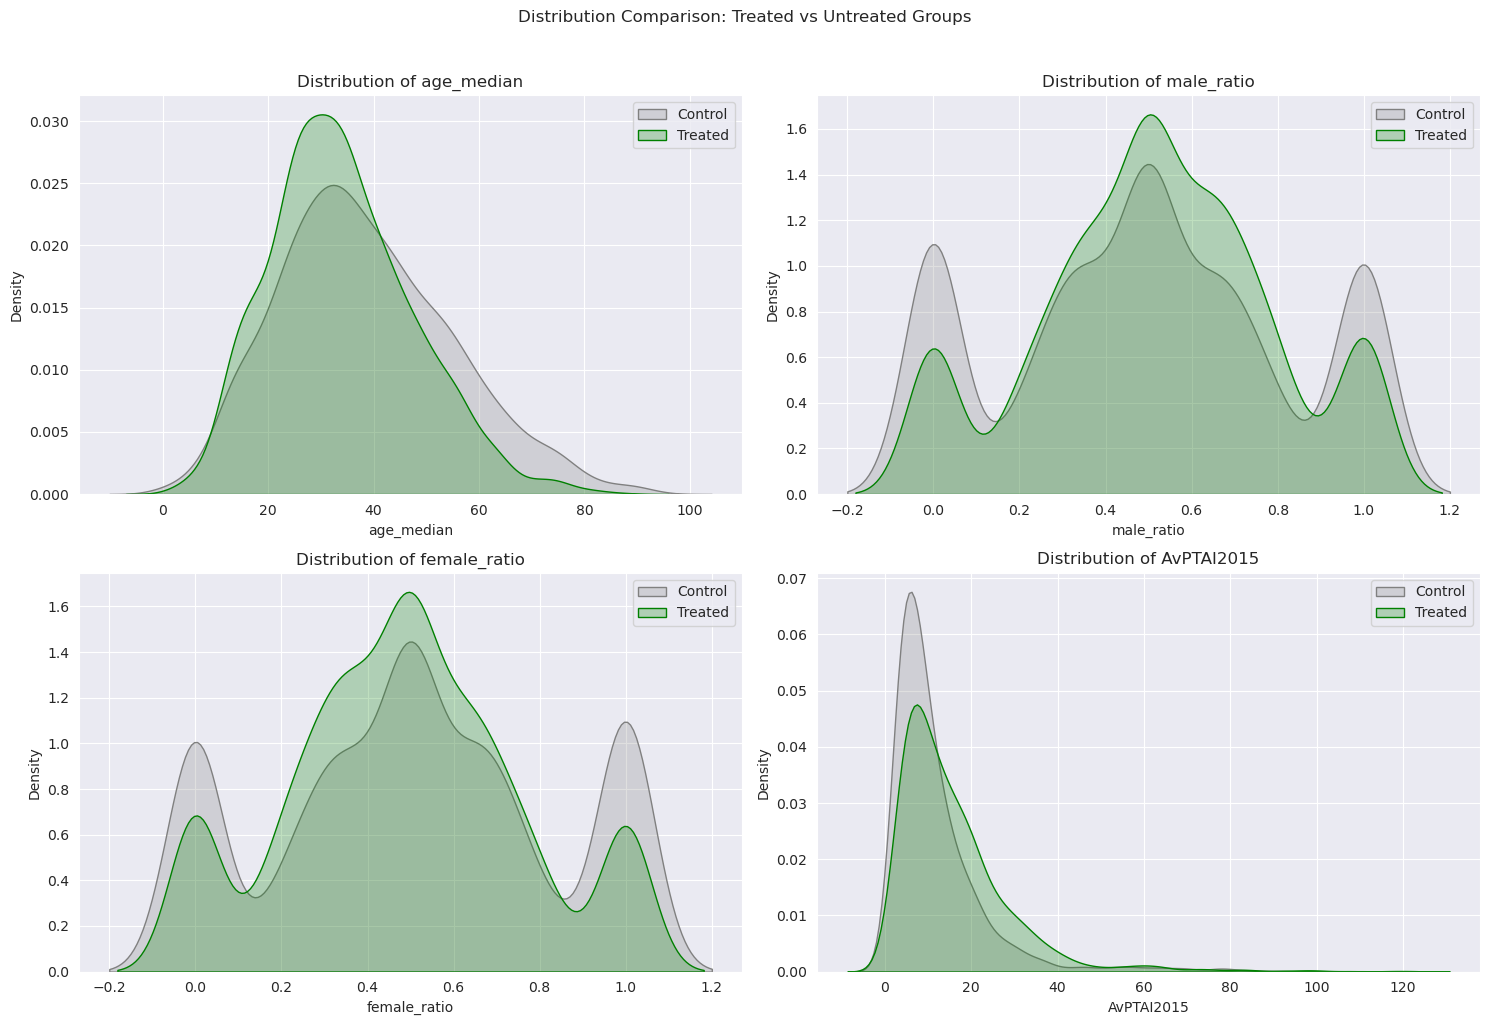

In [29]:
# Set up the plot
plt.figure(figsize=(15, 10))

# Variables to plot
variables = [ 'age_median', 'male_ratio',
            'female_ratio', 'AvPTAI2015']

# Colors and labels
C_COLOUR = 'grey'
T_COLOUR = 'green'
C_LABEL = 'Control'
T_LABEL = 'Treated'

# Create subplots
for idx, var in enumerate(variables, 1):
    plt.subplot(2, 2, idx)

    # Plot untreated group
    sns.kdeplot(data=PSM_lsoa[PSM_lsoa['treat'] == 0], x=var,
                fill=True, color=C_COLOUR, label=C_LABEL)

    # Plot treated group
    sns.kdeplot(data=PSM_lsoa[PSM_lsoa['treat'] == 1], x=var,
                fill=True, color=T_COLOUR, label=T_LABEL)

    plt.title(f'Distribution of {var}')
    plt.legend()

plt.suptitle('Distribution Comparison: Treated vs Untreated Groups', y=1.02)
plt.tight_layout()
plt.show()

T-tests confirm significant differences between control and treatment groups across all variables, allowing us to confidently conclude substantial differences exist between them.

In [30]:
def perform_ttest(group1, group2):
    t_stat, p_val = ttest_ind(group1, group2, equal_var=False)
    return t_stat, p_val

# Variables to test
variables = ['age_median', 'male_ratio',
            'female_ratio', 'AvPTAI2015']

# Split into treated and control groups
treated = PSM_lsoa[PSM_lsoa['treat'] == 1]
control = PSM_lsoa[PSM_lsoa['treat'] == 0]

# Perform t-tests and store results
ttest_results = []
for var in variables:
    t_stat, p_val = perform_ttest(treated[var], control[var])
    ttest_results.append({
        'Variable': var,
        'T-Statistic': round(t_stat, 3),
        'P-Value': round(p_val, 3)
    })

# Create results DataFrame
ttest_results_df = pd.DataFrame(ttest_results)

# Display results with significance indicators
ttest_results_df['Significant'] = ttest_results_df['P-Value'].apply(
    lambda x: '***' if x < 0.001 else
             '**' if x < 0.01 else
             '*' if x < 0.05 else
             'ns'
)

print("T-test Results (*** p<0.001, ** p<0.01, * p<0.05, ns: not significant)")
print(ttest_results_df)

T-test Results (*** p<0.001, ** p<0.01, * p<0.05, ns: not significant)
       Variable  T-Statistic  P-Value Significant
0    age_median      -10.180    0.000         ***
1    male_ratio        2.643    0.008          **
2  female_ratio       -2.643    0.008          **
3    AvPTAI2015       10.269    0.000         ***


#### Estimating propensity scores

Logistic Regression is used to calculate propensity scores to tell us how likely each person is to be in the treatment group based on their characteristics (the covariates).

In [31]:
# Prepare features (X) and treatment variable (y)
features = ['age_median', 'male_ratio', 'female_ratio', 'AvPTAI2015']
X = PSM_lsoa[features]
y = PSM_lsoa['treat']

# Fit logistic regression model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X, y)

# Calculate and add propensity scores to dataframe
PSM_lsoa['propensity_score'] = log_reg.predict_proba(X)[:, 1]

# Print model coefficients
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': log_reg.coef_[0]
})
print("\nLogistic Regression Coefficients:")
print(coef_df)

# Calculate summary statistics of propensity scores
print("\nPropensity Score Summary:")
print(PSM_lsoa.groupby('treat')['propensity_score'].describe())

PSM_lsoa.head()


Logistic Regression Coefficients:
        Feature  Coefficient
0    age_median    -0.020950
1    male_ratio     0.118120
2  female_ratio    -0.133347
3    AvPTAI2015     0.027776

Propensity Score Summary:
        count      mean       std       min       25%       50%       75%  \
treat                                                                       
0      2749.0  0.382797  0.106283  0.120424  0.311814  0.378737  0.441916   
1      1847.0  0.430253  0.101974  0.167965  0.365173  0.422691  0.479956   

            max  
treat            
0      0.920198  
1      0.934771  


,lsoa_of_casualty,casualty_total,age_median,male_count,female_count,male_ratio,female_ratio,totalpop_2015,casualty_rate_per_1000,casualty_imd_decile,AvPTAI2015,treat,propensity_score
0,E01000001,1,40.0,0,1,0.000000,1.000000,1296,0.771605,9,69.8233,0,0.721674
1,E01000002,1,74.0,1,0,1.000000,0.000000,1156,0.865052,9,83.7820,0,0.706750
2,E01000003,5,58.0,1,4,0.200000,0.800000,1350,3.703704,5,41.7417,0,0.461570
3,E01000005,2,30.5,1,1,0.500000,0.500000,1121,1.784121,4,85.8893,0,0.848616
4,E01000006,7,27.0,5,2,0.714286,0.285714,2040,3.431373,4,22.4558,0,0.522255


#### Checking Common Support

Propensity scores help us match people in the treated and untreated groups who are similar,allowing for fair comparison of the outcome variable.

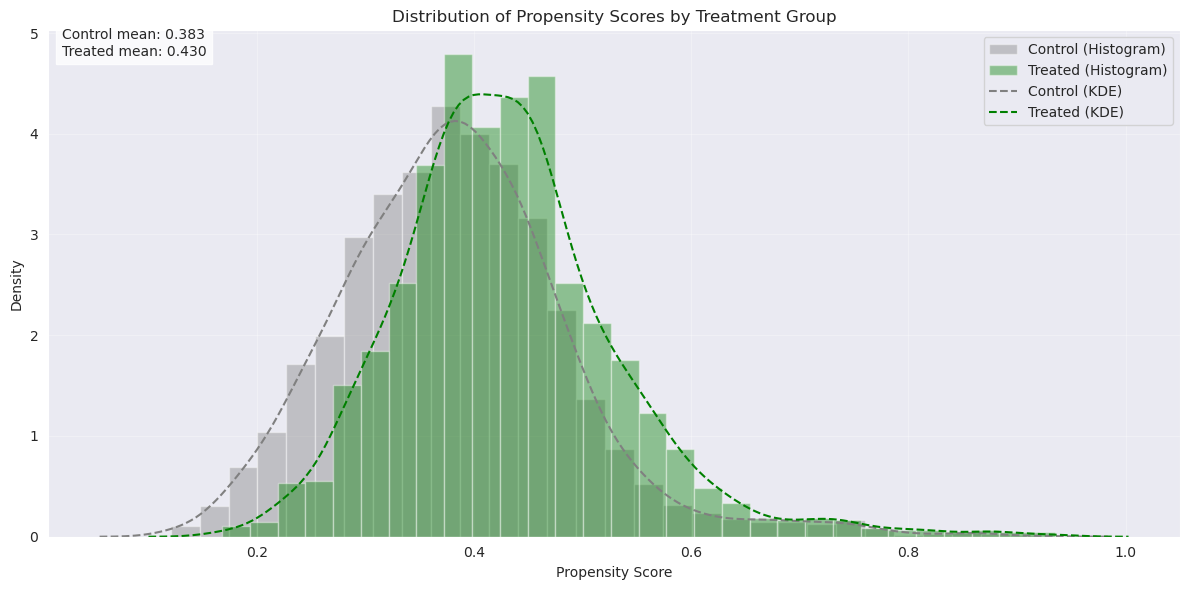

In [32]:
plt.figure(figsize=(12, 6))

# Plot histograms with KDE
plt.hist(PSM_lsoa[PSM_lsoa['treat'] == 0]['propensity_score'],
         bins=30, alpha=0.4, color=C_COLOUR, label=f'{C_LABEL} (Histogram)',
         density=True)
plt.hist(PSM_lsoa[PSM_lsoa['treat'] == 1]['propensity_score'],
         bins=30, alpha=0.4, color=T_COLOUR, label=f'{T_LABEL} (Histogram)',
         density=True)

# Add KDE plots
sns.kdeplot(data=PSM_lsoa[PSM_lsoa['treat'] == 0], x='propensity_score',
            color=C_COLOUR, linestyle='--', label=f'{C_LABEL} (KDE)')
sns.kdeplot(data=PSM_lsoa[PSM_lsoa['treat'] == 1], x='propensity_score',
            color=T_COLOUR, linestyle='--', label=f'{T_LABEL} (KDE)')

# Customize plot
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.title('Distribution of Propensity Scores by Treatment Group')
plt.legend()
plt.grid(True, alpha=0.3)

# Add descriptive text
plt.text(0.02, plt.ylim()[1]*0.95,
         f"Control mean: {PSM_lsoa[PSM_lsoa['treat']==0]['propensity_score'].mean():.3f}\n" +
         f"Treated mean: {PSM_lsoa[PSM_lsoa['treat']==1]['propensity_score'].mean():.3f}",
         fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

If the propensity score distributions exhibit substantial overlap between treated and untreated groups yet with less distinct separation, which is called common support, would be ideal for causal inference. And here we do find the big overlap.

#### Matching

Using nearest neighbour matching, we find the untreated unit with the most similar propensity score for each treated unit.

In [34]:
# Clean dataframe to remove unnecessary columns for matching
# Select only required columns
columns_to_keep = [
    'lsoa_of_casualty',
    'casualty_rate_per_1000',
    'age_median',
    'male_ratio',
    'female_ratio',
    'AvPTAI2015',
    'treat',
    'propensity_score'
]

PSM_lsoa = PSM_lsoa[columns_to_keep]

# Verify the columns
PSM_lsoa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4596 entries, 0 to 4595
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   lsoa_of_casualty        4596 non-null   object 
 1   casualty_rate_per_1000  4596 non-null   float64
 2   age_median              4596 non-null   float64
 3   male_ratio              4596 non-null   float64
 4   female_ratio            4596 non-null   float64
 5   AvPTAI2015              4596 non-null   float64
 6   treat                   4596 non-null   int64  
 7   propensity_score        4596 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 287.4+ KB


In [35]:
# Sort by propensity score
PSM_lsoa.sort_values('propensity_score', inplace=True)

# Create columns for matches and distances
PSM_lsoa['match'] = None
PSM_lsoa['distance'] = None

n = len(PSM_lsoa)-1

# Loop through each row
for i, (ind, row) in enumerate(PSM_lsoa.iterrows()):
    # Only find matches for treated LSOAs
    if row['treat'] == 1:
        # Look for matches in units above current position
        if i < n:
            above = PSM_lsoa.iloc[i:]
            control_above = above[above['treat'] == 0]
            if not control_above.empty:
                match_above = control_above.iloc[0]
                distance_above = abs(match_above['propensity_score'] - row['propensity_score'])
                PSM_lsoa.loc[ind, 'match'] = match_above['lsoa_of_casualty']
                PSM_lsoa.loc[ind, 'distance'] = distance_above

        # Look for matches in units below current position
        if i > 0:
            below = PSM_lsoa.iloc[:i]
            control_below = below[below['treat'] == 0]
            if not control_below.empty:
                match_below = control_below.iloc[-1]
                distance_below = abs(match_below['propensity_score'] - row['propensity_score'])

                # If no above match was found or below match is closer
                if (i == n) or ('distance' not in locals()) or (distance_below < distance_above):
                    PSM_lsoa.loc[ind, 'match'] = match_below['lsoa_of_casualty']
                    PSM_lsoa.loc[ind, 'distance'] = distance_below

# Show matched treated units
matched_pairs = PSM_lsoa[PSM_lsoa['treat'] == 1].dropna(subset=['match'])
print(f"\nNumber of matched pairs: {len(matched_pairs)}")
print("\nFirst few matched pairs:")
print(matched_pairs[['lsoa_of_casualty', 'match', 'distance']].head())


Number of matched pairs: 1847

First few matched pairs:
     lsoa_of_casualty      match  distance
3698        E01003987  E01000563  0.000312
2158        E01002325  E01001451  0.000267
3297        E01003545  E01002256  0.000166
1703        E01001841  E01002285   0.00018
1317        E01001412  E01003856  0.000647


In [36]:
# TO compare the matched pairs, we need to merge the treated and control groups based on the matched LSOA
COLUMNS = [
    'age_median',
    'male_ratio',
    'female_ratio',
    'AvPTAI2015',
    'propensity_score',
    'lsoa_of_casualty',
    'casualty_rate_per_1000'
]

# Create matches DataFrame
matches = pd.merge(
    PSM_lsoa[PSM_lsoa['treat'] == 1][COLUMNS + ['match']],
    PSM_lsoa[COLUMNS],
    left_on='match',
    right_on='lsoa_of_casualty',
    how='left',
    suffixes=('_treated', '_control')
)

In [37]:
matches.head(20)

,age_median_treated,male_ratio_treated,female_ratio_treated,AvPTAI2015_treated,propensity_score_treated,lsoa_of_casualty_treated,casualty_rate_per_1000_treated,match,age_median_control,male_ratio_control,female_ratio_control,AvPTAI2015_control,propensity_score_control,lsoa_of_casualty_control,casualty_rate_per_1000_control
0,75.0,0.000000,1.000000,4.311750,0.167965,E01003987,0.533903,E01000563,83.0,0.666667,0.333333,4.22988,0.167653,E01000563,2.121641
1,76.0,0.333333,0.666667,3.230530,0.172604,E01002325,1.632209,E01001451,79.0,0.000000,1.000000,8.44367,0.172337,E01001451,0.616143
2,75.0,0.000000,1.000000,6.315590,0.175887,E01003545,0.560852,E01002256,71.5,0.000000,1.000000,3.63439,0.175721,E01002256,1.298701
3,82.0,0.500000,0.500000,7.211440,0.176463,E01001841,1.285347,E01002285,75.0,0.000000,1.000000,6.41369,0.176283,E01002285,0.812348
4,70.0,0.666667,0.333333,0.567043,0.192828,E01001412,1.681614,E01003856,72.5,0.000000,1.000000,8.33843,0.192181,E01003856,1.232286
5,71.5,0.500000,0.500000,6.393680,0.206979,E01001502,2.110818,E01001108,60.0,0.000000,1.000000,2.22322,0.206873,E01001108,1.658375
6,82.0,0.333333,0.666667,16.386500,0.209562,E01002027,1.884422,E01000683,61.0,0.000000,1.000000,3.21424,0.207954,E01000683,0.617665
7,76.0,1.000000,0.000000,5.856580,0.209706,E01002120,0.720981,E01001122,61.0,0.000000,1.000000,3.56812,0.209578,E01001122,0.640205
8,63.0,0.000000,1.000000,5.177450,0.210042,E01001287,2.721088,E01001865,74.0,0.800000,0.200000,6.18660,0.209835,E01001865,2.862049
9,72.0,0.000000,1.000000,12.068400,0.210515,E01001930,1.620746,E01001865,74.0,0.800000,0.200000,6.18660,0.209835,E01001865,2.862049


The distribution should look more similar between the groups after the matching. Let’s visualize the distributions. As is shown below, most confounder distributions look more balanced between the groups than before.

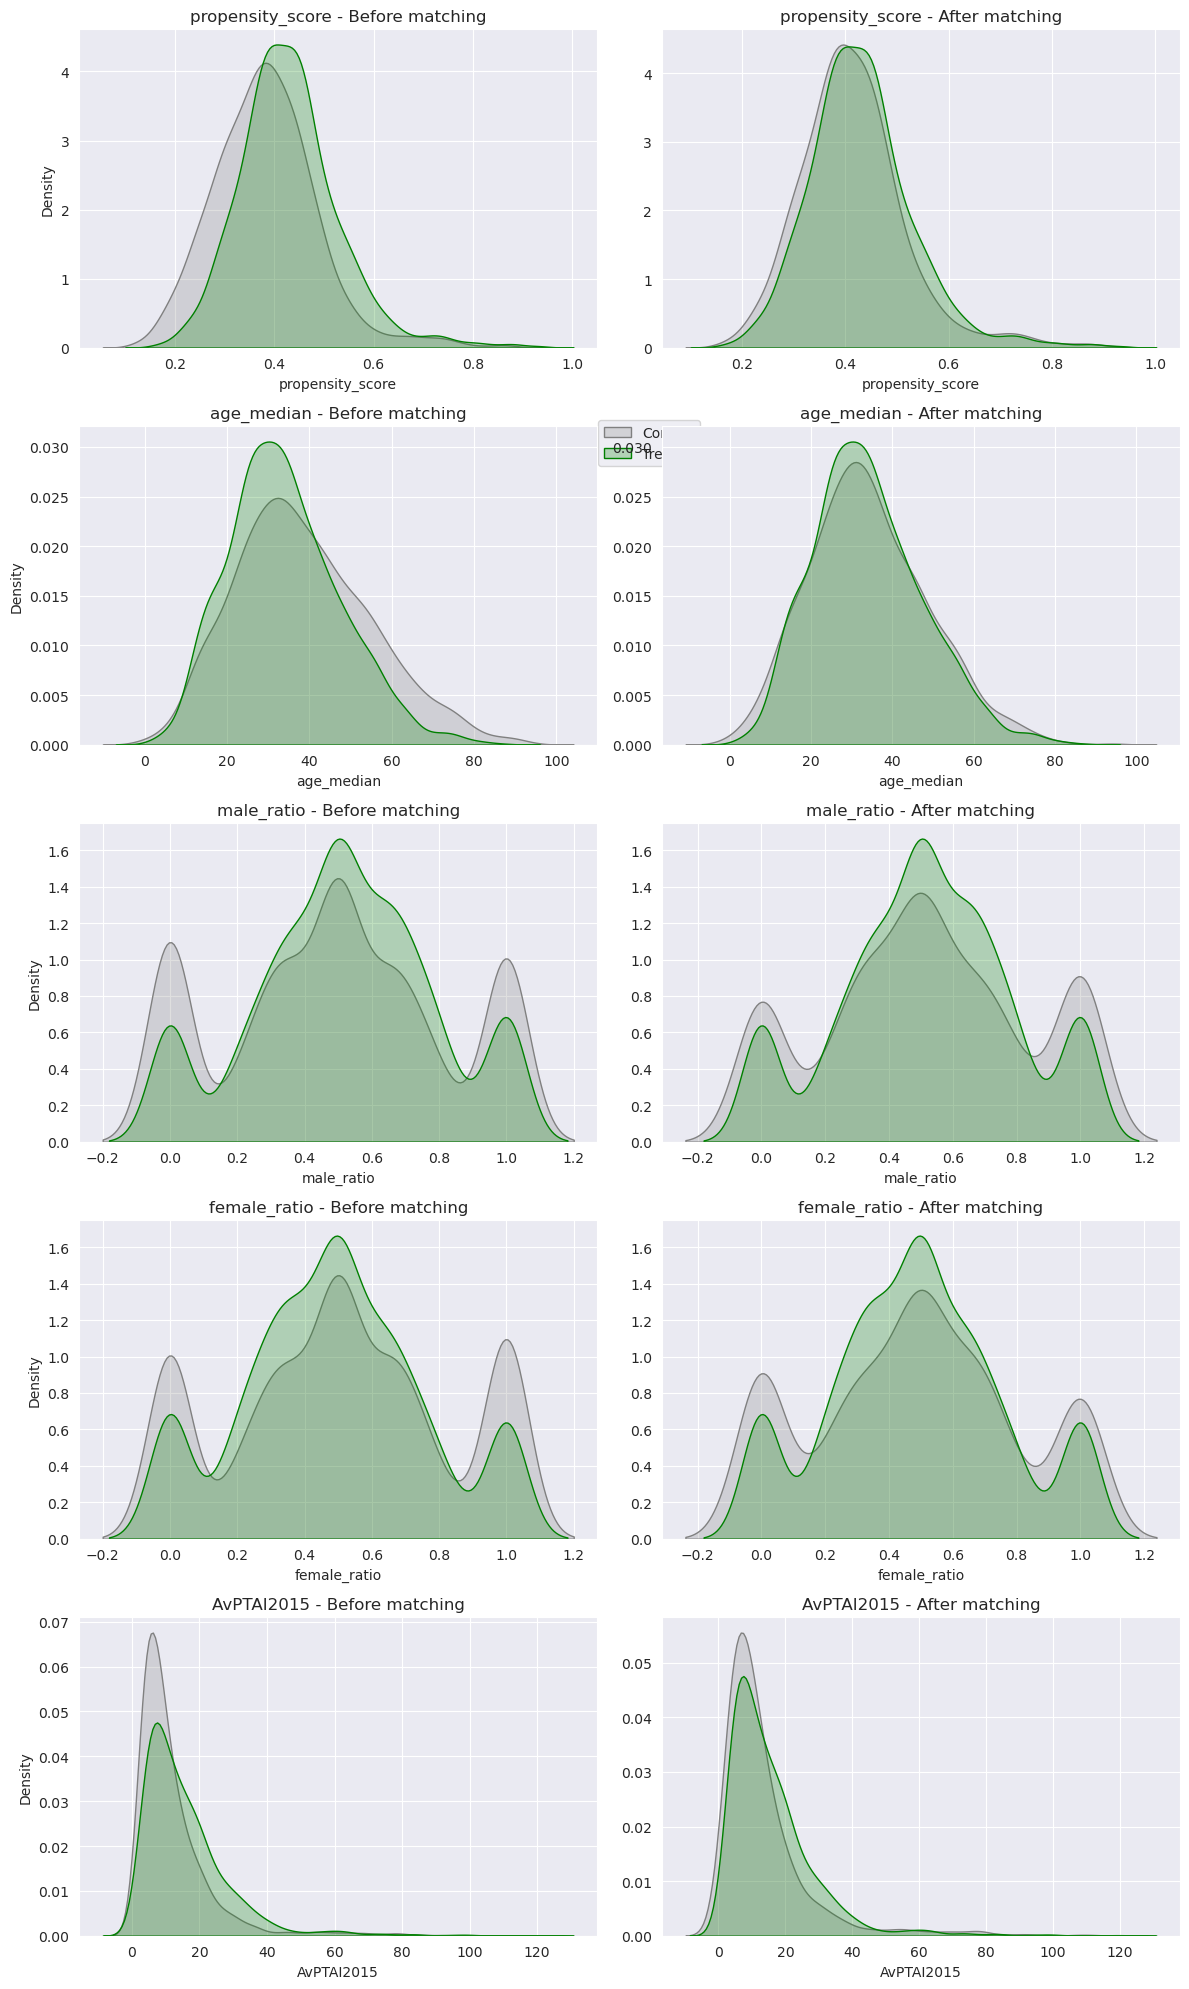

In [38]:
# Variables to plot
variables = ['propensity_score', 'age_median', 'male_ratio', 'female_ratio', 'AvPTAI2015']

# Create figure with subplots
fig, axes = plt.subplots(len(variables), 2, figsize=(12, 4*len(variables)))

# Colors and labels
C_COLOUR = 'grey'
T_COLOUR = 'green'
C_LABEL = 'Control'
T_LABEL = 'Treated'

# Plot each variable
for i, var in enumerate(variables):
    # Before matching
    sns.kdeplot(data=PSM_lsoa[PSM_lsoa['treat'] == 0], x=var,
                fill=True, color=C_COLOUR, label=C_LABEL, ax=axes[i,0])
    sns.kdeplot(data=PSM_lsoa[PSM_lsoa['treat'] == 1], x=var,
                fill=True, color=T_COLOUR, label=T_LABEL, ax=axes[i,0])
    axes[i,0].set_title(f'{var} - Before matching')

    # After matching
    sns.kdeplot(data=PSM_lsoa[PSM_lsoa['lsoa_of_casualty'].isin(matches['match'])],
                x=var, fill=True, color=C_COLOUR, label=C_LABEL, ax=axes[i,1])
    sns.kdeplot(data=PSM_lsoa[PSM_lsoa['lsoa_of_casualty'].isin(matches['lsoa_of_casualty_treated'])],
                x=var, fill=True, color=T_COLOUR, label=T_LABEL, ax=axes[i,1])
    axes[i,1].set_title(f'{var} - After matching')
    axes[i,1].set_ylabel("")

# Adjust layout
plt.tight_layout()
axes[0,0].legend(loc='center', bbox_to_anchor=(1.1, -0.3))
plt.show()

#### Results for PSM

Propensity scores enables us to calculate the average treatment effect on treatment (ATT), which measures the influence of the treatment solely on the individuals who got it. This allows us to determine whether living in more deprived areas leads to a higher rate of pedestrian casualties.

In [ ]:
# Calculate ATT using matched pairs
att = matches['casualty_rate_per_1000_treated'].mean() - matches['casualty_rate_per_1000_control'].mean()

# Calculate summary statistics for both groups
summary = pd.DataFrame({
    'Treated': matches['casualty_rate_per_1000_treated'].describe(),
    'Control': matches['casualty_rate_per_1000_control'].describe()
})

# Add ATT to summary
summary.loc['ATT'] = [att, None]

print("\nSummary Statistics:")
print(summary)
print(f"\nAverage Treatment Effect on Treated (ATT): {att:.4f}")

Assuming we have accounted for all the confounders in this study, we can now infer that living in 30% most deprived London LSOAs causes approximately 81% higher pedestrian casualty rate compared to similar residents in more affluent areas based on ATT results.

### K-modes Clustering

#### Datesets

In [39]:
# Select Categorical variables we have chosen for K-modes clustering in Raw data cleaning
Kmodes_data = pedestrian_data[['sex_of_casualty','age_band_of_casualty', 'casualty_severity', 'casualty_imd_decile', 'pedestrian_location','road_surface_conditions','light_conditions','pedestrian_crossing_physical_facilities','PTAL', 'time_of_day']].copy()

In [40]:
# Check missing values in Kmodes_data
# According to metadata,-1 or 9 refers to missing values in certain columns
# Variables which can be checked by using null method have been proven to no more missing values

# Scenario 1: Missing values = -1
variables1 = ['sex_of_casualty', 'light_conditions']
print("Scenario 1: Missing values coded as -1")
for var in variables1:
    missing_count = Kmodes_data[Kmodes_data[var] == -1].shape[0]
    missing_pct = (missing_count / len(Kmodes_data)) * 100
    print(f"{var} missing values: {missing_count} ({missing_pct:.2f}%)")

# Scenario 2: Missing values = -1 or 9
variables2 = ['road_surface_conditions', 'age_band_of_casualty', 'pedestrian_crossing_physical_facilities']
print("\nScenario 2: Missing values coded as -1 or 9")
for var in variables2:
    missing_count = Kmodes_data[(Kmodes_data[var] == -1) | (Kmodes_data[var] == 9)].shape[0]
    missing_pct = (missing_count / len(Kmodes_data)) * 100
    print(f"{var} missing values: {missing_count} ({missing_pct:.2f}%)")

# Scenario 3: Missing values = -1, 9, or 10
variables3 = ['pedestrian_location']
print("\nScenario 3: Missing values coded as -1, 9, or 10")
for var in variables3:
    missing_count = Kmodes_data[(Kmodes_data[var] == -1) | (Kmodes_data[var] == 9) | (Kmodes_data[var] == 10)].shape[0]
    missing_pct = (missing_count / len(Kmodes_data)) * 100
    print(f"{var} missing values: {missing_count} ({missing_pct:.2f}%)")

Scenario 1: Missing values coded as -1
sex_of_casualty missing values: 128 (0.61%)
light_conditions missing values: 0 (0.00%)

Scenario 2: Missing values coded as -1 or 9
road_surface_conditions missing values: 819 (3.90%)
age_band_of_casualty missing values: 2281 (10.85%)
pedestrian_crossing_physical_facilities missing values: 1696 (8.07%)

Scenario 3: Missing values coded as -1, 9, or 10
pedestrian_location missing values: 3419 (16.27%)


As the percentage of missing values is high in pedestrian_location(16%) and other columns(10%) , we choose to drop pedestrian_location and fill others with their modes to avoid excessive uncertainty.

In [41]:
# dealing with missing values
Kmodes_data = Kmodes_data.drop(columns=['pedestrian_location'])

for column in ['sex_of_casualty', 'road_surface_conditions', 'age_band_of_casualty',
               'pedestrian_crossing_physical_facilities']:
    Kmodes_data[column] = Kmodes_data[column].fillna(Kmodes_data[column].mode()[0])
# Transform all data to categorical variables as some of them are int64
for col in Kmodes_data.select_dtypes(include=['int64']).columns:
    Kmodes_data[col] = Kmodes_data[col].astype(str)

In [42]:
Kmodes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21015 entries, 0 to 21014
Data columns (total 9 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   sex_of_casualty                          21015 non-null  object
 1   age_band_of_casualty                     21015 non-null  object
 2   casualty_severity                        21015 non-null  object
 3   casualty_imd_decile                      21015 non-null  object
 4   road_surface_conditions                  21015 non-null  object
 5   light_conditions                         21015 non-null  object
 6   pedestrian_crossing_physical_facilities  21015 non-null  object
 7   PTAL                                     21015 non-null  object
 8   time_of_day                              21015 non-null  object
dtypes: object(9)
memory usage: 1.4+ MB


We divide the dataset into a low IMD subset (deciles = 1, 2, 3) and a high IMD subset (rest deciles) to examine how deprivation level impacts clustering results.

In [43]:
# Create low IMD subset (deciles 1-3)
low_imd = Kmodes_data[Kmodes_data['casualty_imd_decile'].isin(['1', '2', '3'])]

# Create high IMD subset (deciles 8-10)
high_imd = Kmodes_data[Kmodes_data['casualty_imd_decile'].isin(['4','5','6','7','8', '9', '10'])]

# Print the sizes of subsets
print(f"Low IMD subset (deciles 1-3): {len(low_imd)} records")
print(f"High IMD subset (deciles 4-10): {len(high_imd)} records")

# Verify IMD deciles in each subset
print("\nIMD deciles in low IMD subset:")
print(low_imd['casualty_imd_decile'].value_counts().sort_index())
print("\nIMD deciles in high IMD subset:")
print(high_imd['casualty_imd_decile'].value_counts().sort_index())

Low IMD subset (deciles 1-3): 10704 records
High IMD subset (deciles 4-10): 10311 records

IMD deciles in low IMD subset:
casualty_imd_decile
1    1602
2    4697
3    4405
Name: count, dtype: int64

IMD deciles in high IMD subset:
casualty_imd_decile
10     337
4     2986
5     2169
6     1735
7     1294
8     1027
9      763
Name: count, dtype: int64


In [44]:
# Remove casualty_imd_decile from both subsets as we do not need it
# for clustering and just use it for create these two subsets
low_imd = low_imd.drop('casualty_imd_decile', axis=1)
high_imd = high_imd.drop('casualty_imd_decile', axis=1)

# Verify columns in both subsets
print("Columns in low IMD subset:")
print(low_imd.columns.tolist())
print("\nColumns in high IMD subset:")
print(high_imd.columns.tolist())

Columns in low IMD subset:
['sex_of_casualty', 'age_band_of_casualty', 'casualty_severity', 'road_surface_conditions', 'light_conditions', 'pedestrian_crossing_physical_facilities', 'PTAL', 'time_of_day']

Columns in high IMD subset:
['sex_of_casualty', 'age_band_of_casualty', 'casualty_severity', 'road_surface_conditions', 'light_conditions', 'pedestrian_crossing_physical_facilities', 'PTAL', 'time_of_day']


Table 2 Variables for K-modes

| Variable                                | Type        | Description                                                                   |
|-----------------------------------------|-------------|-------------------------------------------------------------------------------|
| sex_of_casualty                         | Categorical | Male or female.                                                               |
| age_band_of_casualty                    | Categorical | Such as 0-5,6-10.                                                             |
| casualty_severity                       | Categorical | Such as fatal or slight.                                                      |
| road_surface_conditions                 | Categorical | Such as dry or wet.                                                           |
| light_conditions                        | Categorical | Whether there was light when pedestrians got hurt.                            |
| pedestrian_crossing_physical_facilities | Categorical | Facilities help pedestrians went across streets. .                            |
| PTAL                                    | Categorical | Average Public Transport Accessibility Level in LSOAs which pedestrians live. |
| time_of_day                             | Categorical | Time when the accident happenned.                                             |

Though ideally high IMD would only include deciles 8-10 compared to low IMD's 1-3, the size of two subsets needs balance to explore comparable clustering results.

#### Clustering

We use the "Cao" method to initialise the K-modes algorithm, as it performs better than "Huang" method in calculation time.

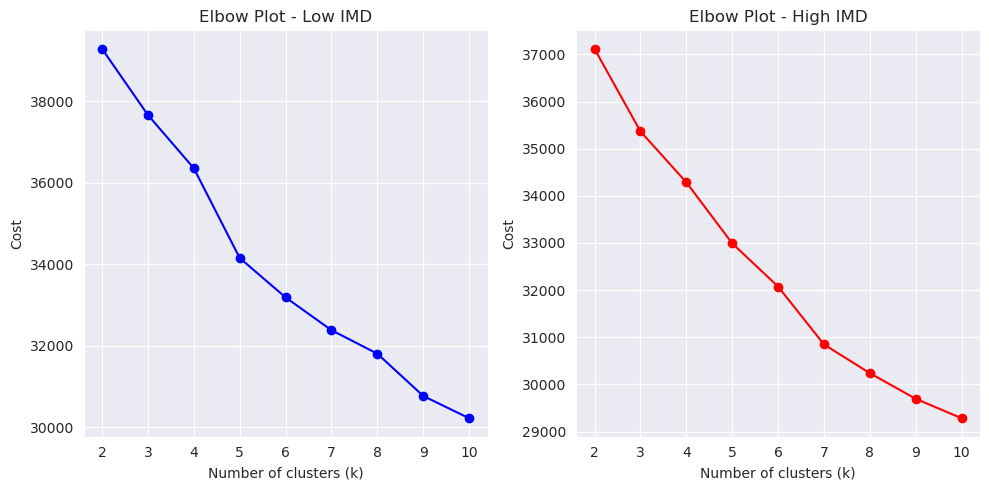

In [45]:
# Function to perform k-modes clustering
def perform_kmodes(data, k_range):
    cost_list = []

    # Try different k values
    #
    for k in k_range:
        kmode = KModes(n_clusters=k, init='Cao', n_init=30, verbose=0, random_state=42)
        kmode.fit(data)
        cost_list.append(kmode.cost_)

    return cost_list

# Define range of k to try
k_range = range(2, 11)

# Perform k-modes for both subsets
low_imd_costs = perform_kmodes(low_imd, k_range)
high_imd_costs = perform_kmodes(high_imd, k_range)

# Plot elbow curves
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(list(k_range), low_imd_costs, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Plot - Low IMD')

plt.subplot(1, 2, 2)
plt.plot(list(k_range), high_imd_costs, 'ro-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Plot - High IMD')

plt.tight_layout()
plt.show()

The low IMD subset shows a clear elbow at k=4, while the high IMD subset has a more gradual decrease in cost. Considering the balance between interpretability and complexity, we choose k=4 for both subsets.

In [46]:
# Perform final clustering with k=4 for both datasets
kmode_low = KModes(n_clusters=4, init='Cao', n_init=30, verbose=0, random_state=42)
kmode_high = KModes(n_clusters=4, init='Cao', n_init=30, verbose=0, random_state=42)

# Fit and predict clusters
low_clusters = kmode_low.fit_predict(low_imd)
high_clusters = kmode_high.fit_predict(high_imd)

# Add cluster labels as new columns
low_imd['cluster'] = low_clusters
high_imd['cluster'] = high_clusters


# Verify results
print("Low IMD cluster distribution:")
print(low_imd['cluster'].value_counts())
print("\nHigh IMD cluster distribution:")
print(high_imd['cluster'].value_counts())

Low IMD cluster distribution:
cluster
0    6655
1    2055
2    1062
3     932
Name: count, dtype: int64

High IMD cluster distribution:
cluster
0    6317
1    2040
2    1114
3     840
Name: count, dtype: int64


In [47]:
high_imd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10311 entries, 0 to 21013
Data columns (total 9 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   sex_of_casualty                          10311 non-null  object
 1   age_band_of_casualty                     10311 non-null  object
 2   casualty_severity                        10311 non-null  object
 3   road_surface_conditions                  10311 non-null  object
 4   light_conditions                         10311 non-null  object
 5   pedestrian_crossing_physical_facilities  10311 non-null  object
 6   PTAL                                     10311 non-null  object
 7   time_of_day                              10311 non-null  object
 8   cluster                                  10311 non-null  uint16
dtypes: object(8), uint16(1)
memory usage: 745.1+ KB


After creating a mapping dictionary to translate numerical values to real-world meanings, we use heatmaps to visualise cluster profiles in both subsets.

In [48]:
# Create mapping dictionaries
mappings = {
    'age_band_of_casualty': {
        '1': '0 - 5', '2': '6 - 10', '3': '11 - 15', '4': '16 - 20',
        '5': '21 - 25', '6': '26 - 35', '7': '36 - 45', '8': '46 - 55',
        '9': '56 - 65', '10': '66 - 75', '11': 'Over 75'
    },
    'sex_of_casualty': {'1': 'Male', '2': 'Female'},
    'casualty_severity': {'1': 'Fatal', '2': 'Serious', '3': 'Slight'},
    'road_surface_conditions': {
        '1': 'Dry', '2': 'Wet or damp', '3': 'Snow', '4': 'Frost or ice',
        '5': 'Flood over 3cm deep', '6': 'Oil or diesel', '7': 'Mud'
    },
    'light_conditions': {
        '1': 'Daylight', '4': 'Darkness - lights lit',
        '5': 'Darkness - lights unlit', '6': 'Darkness - no lighting',
        '7': 'Darkness - lighting unknown'
    },
    'pedestrian_crossing_physical_facilities': {
        '0': 'No facilities', '1': 'Zebra',
        '4': 'Pelican or similar', '7': 'Footbridge or subway',
        '8': 'Central refuge', '5': 'Pedestrian phase'
    }
}

# Replace values in both datasets
for column, mapping in mappings.items():
    low_imd[column] = low_imd[column].map(mapping)
    high_imd[column] = high_imd[column].map(mapping)

# Verify the changes
for column in mappings.keys():
    print(f"\n{column} values in low IMD:")
    print(low_imd[column].value_counts().head())


age_band_of_casualty values in low IMD:
age_band_of_casualty
26 - 35    1885
36 - 45    1364
46 - 55    1316
11 - 15    1199
21 - 25    1024
Name: count, dtype: int64

sex_of_casualty values in low IMD:
sex_of_casualty
Male      5547
Female    5095
Name: count, dtype: int64

casualty_severity values in low IMD:
casualty_severity
Slight     8132
Serious    2514
Fatal        58
Name: count, dtype: int64

road_surface_conditions values in low IMD:
road_surface_conditions
Dry                    7908
Wet or damp            2329
Frost or ice             41
Snow                     10
Flood over 3cm deep       6
Name: count, dtype: int64

light_conditions values in low IMD:
light_conditions
Daylight                       7340
Darkness - lights lit          2969
Darkness - lighting unknown     274
Darkness - lights unlit          67
Darkness - no lighting           54
Name: count, dtype: int64

pedestrian_crossing_physical_facilities values in low IMD:
pedestrian_crossing_physical_facilities


Low IMD Clusters Profile:
Percentages shape: (4, 8)
Modes shape: (4, 8)

Percentages head:
  sex_of_casualty age_band_of_casualty casualty_severity  \
0       68.084147            21.998497         81.382419   
1       74.452555            24.574209         78.832117   
2       73.917137            31.355932         76.365348   
3            75.0            32.939914         69.313305   

  road_surface_conditions light_conditions  \
0                81.74305        80.045079   
1               67.445255        68.953771   
2               69.020716        60.451977   
3               86.909871        88.626609   

  pedestrian_crossing_physical_facilities       PTAL time_of_day  
0                               54.815928   31.48009   48.369647  
1                                37.03163  37.469586    51.63017  
2                               44.821092  34.651601   47.457627  
3                               37.017167  38.412017   47.639485  

Modes head:
  sex_of_casualty age_band_of

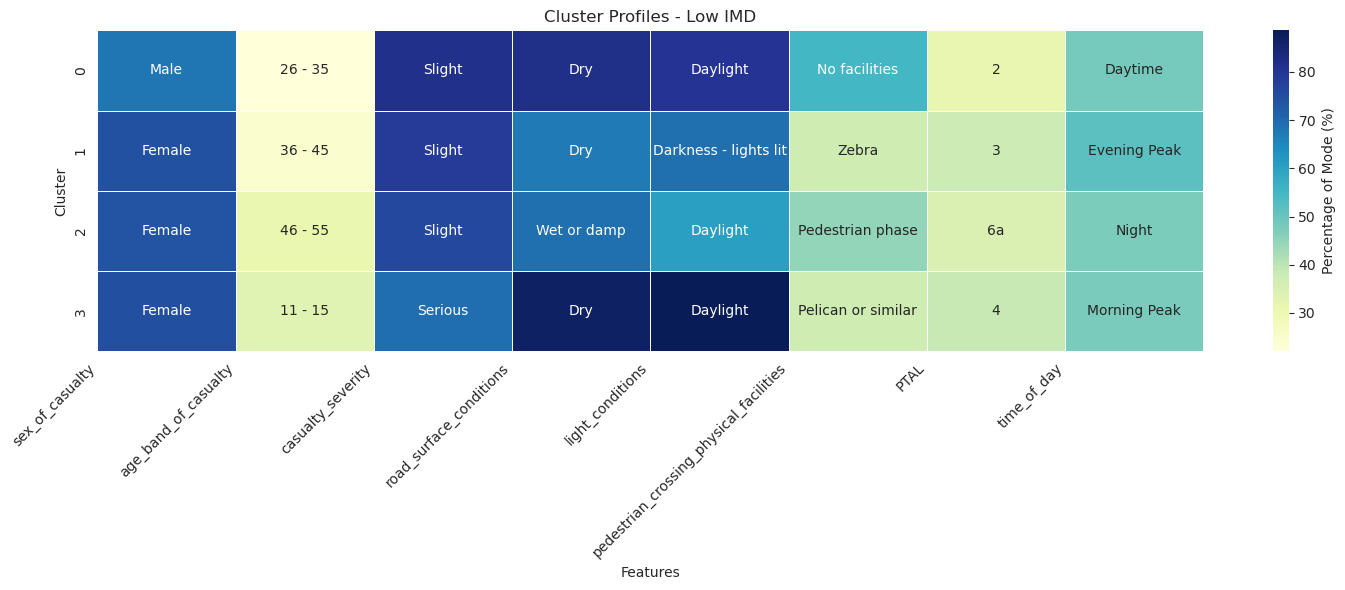


High IMD Clusters Profile:
Percentages shape: (4, 8)
Modes shape: (4, 8)

Percentages head:
  sex_of_casualty age_band_of_casualty casualty_severity  \
0       68.671838            21.624189         77.869242   
1       76.715686            25.147059         78.382353   
2       81.956912            24.147217         78.007181   
3            82.5            28.928571         90.595238   

  road_surface_conditions light_conditions  \
0               75.431376        82.095932   
1               60.637255        75.245098   
2               76.211849        66.068223   
3               76.309524        93.571429   

  pedestrian_crossing_physical_facilities       PTAL time_of_day  
0                               53.728035  41.079626   54.028811  
1                               32.892157   38.77451   51.372549  
2                               40.933573  39.228007   44.793537  
3                               36.785714  37.142857   58.690476  

Modes head:
  sex_of_casualty age_band_

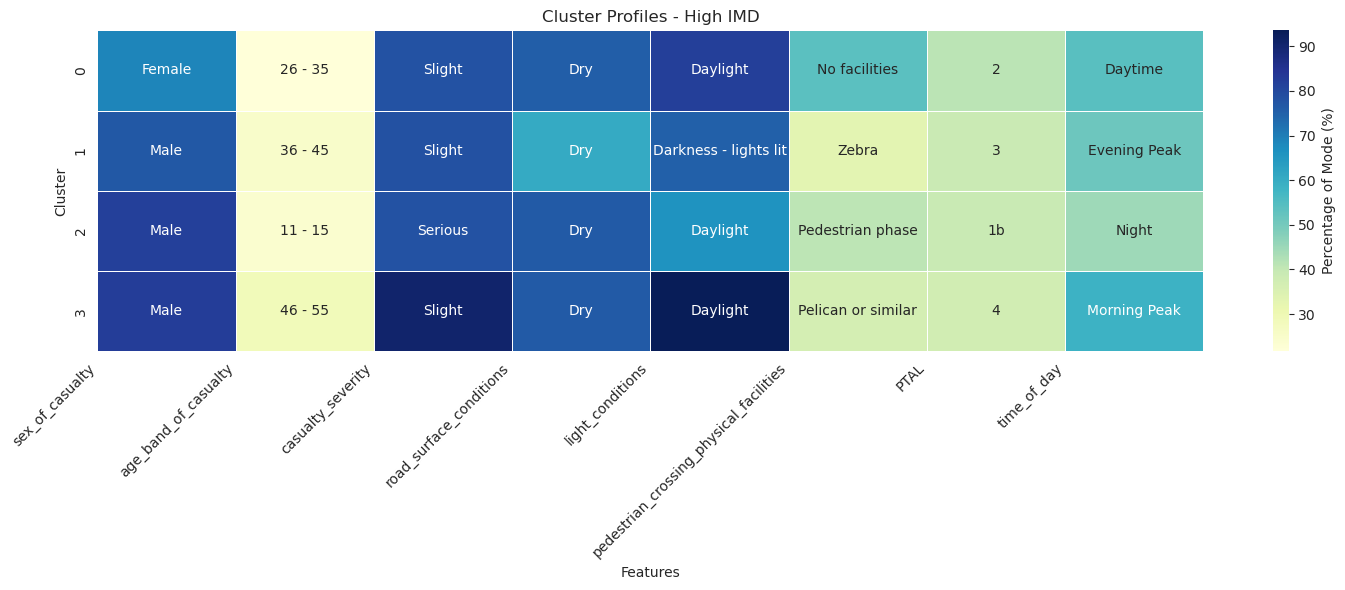

In [49]:
def create_cluster_profile_heatmap(df, title_suffix=""):
    # Get features (excluding cluster)
    features = df.columns.drop('cluster').tolist()
    clusters = sorted(df['cluster'].unique())

    # Create DataFrames for percentages and modes
    percentages = pd.DataFrame(index=clusters, columns=features)
    modes = pd.DataFrame(index=clusters, columns=features)

    # Calculate mode and its percentage for each cluster and feature
    for cluster in clusters:
        cluster_data = df[df['cluster'] == cluster]
        for feature in features:
            # Get value counts and find mode
            value_counts = cluster_data[feature].value_counts()
            mode = value_counts.index[0]  # Most frequent value
            mode_count = value_counts.iloc[0]  # Count of most frequent value

            # Calculate percentage
            mode_pct = (mode_count / len(cluster_data)) * 100

            modes.loc[cluster, feature] = mode
            percentages.loc[cluster, feature] = mode_pct

    # Print shapes and sample data for debugging
    print("Percentages shape:", percentages.shape)
    print("Modes shape:", modes.shape)
    print("\nPercentages head:")
    print(percentages.head())
    print("\nModes head:")
    print(modes.head())

    # Convert percentages to numpy array if needed
    percentages_array = percentages.astype(float).values
    modes_array = modes.values

    # Create heatmap
    plt.figure(figsize=(15, 6))
    ax = sns.heatmap(percentages_array,
                     annot=modes_array,
                     fmt='',
                     cmap='YlGnBu',
                     cbar_kws={'label': 'Percentage of Mode (%)'},
                     linewidths=0.5
    )

    plt.title(f'Cluster Profiles - {title_suffix}')
    plt.ylabel('Cluster')
    plt.xlabel('Features')
    plt.xticks(range(len(features)), features, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    return modes, percentages
# Create cluster profile heatmap for low IMD
print("Low IMD Clusters Profile:")
low_modes, low_percentages = create_cluster_profile_heatmap(low_imd, "Low IMD")

# Create cluster profile heatmap for high IMD
print("\nHigh IMD Clusters Profile:")
high_modes, high_percentages = create_cluster_profile_heatmap(high_imd, "High IMD")

#### Results

Table 3 Cluster comparison between low IMD and high IMD

| Low IMD reference cluster                 | Modal profile (low-IMD) | Matching cluster in high IMD | How the pattern shifts in high IMD                                                                                                   |
|-------------------------------------------|---|------------------------------|--------------------------------------------------------------------------------------------------------------------------------------|
| L-C0 (62%)<br>*“Day-time commuters”*      | Male 26–35 yr<br>Slight injury<br>Dry road, daylight<br>No facility<br>PTAL 2 (low)<br>Day-time | H-C0 (61%)                   | Female now dominate (69%)<br>All other features unchanged                                                                            |
| L-C1 (19%)<br>*“Evening zebra users”*     | Female 36–45 yr<br>Slight injury<br>Dry road, street-lit dark<br>Zebra crossing<br>PTAL 3<br>Evening peak | H-C1 (20%)                   | Switch to male (77%)<br>Context (dark zebra, PTAL 3, evening) stays the same                                                         |
| L-C2 (10%)<br>*“Night-time signal users”* | Female 46–55 yr<br>Slight injury<br>Wet/damp road, daylight<br>Ped-phase lights<br>PTAL 6a (high)<br>Night-time | H-C3 (8%)                    | Male 46–55 yr<br>Road mostly dry<br>Crossing becomes pelican<br>PTAL drops to 4<br>Occurs in morning peak not at night               |
| L-C3 (9%)<br>*“School-run pelican”*       | Female 11–15 yr<br>Serious injury<br>Dry road, daylight<br>Pelican crossing<br>PTAL 4<br>Morning peak | H-C2 (11%)                   | Male 11–15 yr<br>Happens at night<br>Crossing shifts to ped-phase<br>PTAL falls to 1b (very poor)<br>Injury severity remains serious |




Using k‑modes, we first identified four clear pedestrian crash patterns in low IMD LSOAs, then found the closest matching patterns in high IMD LSOAs for comparison. Three consistent differences stand out:
 1. Gender dominance reverses: clusters that are male‑dominated in low IMD become female‑dominated in high IMD.
 2. The highest‑risk teenage pattern shifts from supervised morning crossings to unsupervised nighttime crossings with poor transport links.
 3. Middle-aged crashes move from wet‑road, night‑time walks in deprived areas to dry road, morning peak walks in affluent areas.


## Discussion

[[ go back to the top ]](#Table-of-contents)

1.	Propensity score matching successfully aligned treated and untreated LSOAs on age, sex and PTAL, showing that our groups are comparable. Yet this apparent balance may simply reflect the limited covariates used—without data on traffic volume, crossing density or actual walking exposure, unmeasured confounders remain possible.
2.	For clustering, contrasts between low and high IMD crash patterns were smaller than expected, likely because our "high IMD" category pools all areas above the bottom 30%, blending moderately and highly affluent neighbourhoods. Both very low and very high PTAL values appear in high‑risk clusters, suggesting a non‑linear link between transport access and pedestrian risk. Clusters capture crash‑site conditions rather than residents' home environments, so using these findings for local infrastructure planning requires caution.


## Conclusion

[[ go back to the top ]](#Table-of-contents)

1. **Q1**: After balancing on age, sex and accessibility, living in the 30% most‑deprived LSOAs still raises pedestrian casualty rate by nearly 81%.
2. **Q2**: Both low and high IMD areas show four main crash patterns. Gender dominance, crash time shift between casualties in rich and poor areas, but crossing facilities differ little.
3. **Action**: Focus on better nighttime lighting and add safe crossings on uncontrolled roads across deprived areas.


## References

[[ go back to the top ]](#Table-of-contents)



Bonera, M. et al. (2022) ‘Identifying clusters and patterns of road crash involving pedestrians and cyclists. A case study on the Province of Brescia (IT)’, Transportation Research Procedia, 60, pp. 512–519. Available at: [here](https://doi.org/10.1016/j.trpro.2021.12.066).

Feleke, R. et al. (2018) ‘Comparative fatality risk for different travel modes by age, sex, and deprivation. Journal of Transport & Health, 8, pp. 307–320. Available at: [here](https://doi.org/10.1016/j.jth.2017.08.007).

Graham, D., Glaister, S. and Anderson, R. (2005) ‘The effects of area deprivation on the incidence of child and adult pedestrian casualties in England’, Accident Analysis & Prevention, 37(1), pp. 125–135. Available at: [here](https://doi.org/10.1016/j.aap.2004.07.002).

Szubelak, L., 2024. Causal inference with Python: A guide to propensity score matching. [online] Towards Data Science. Available at: [here](https://towardsdatascience.com/causal-inference-with-python-a-guide-to-propensity-score-matching-b3470080c84f) [Accessed 15 Apr. 2025].

Transport for London (TfL). (2018). Vision Zero action plan. Available at: [here](https://content.tfl.gov.uk/vision-zero-action-plan.pdf)(Accessed: 15 April 2025).

Transport for London (TfL), 2023. Inequalities in road danger in London (2017–2021), version 2.0. Mayor of London. Available at: [here](https://content.tfl.gov.uk/inequalities-in-road-danger-in-london.pdf) [Accessed 15 Apr. 2025].

In [51]:
notebook_end_time = time.time()
total_runtime = notebook_end_time - notebook_start_time

# Display runtime in seconds and minutes
print(f"Total notebook runtime: {total_runtime:.2f} seconds")
print(f"Total notebook runtime: {total_runtime/60:.2f} minutes")
print("Notebook execution finished at:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

Total notebook runtime: 122.78 seconds
Total notebook runtime: 2.05 minutes
Notebook execution finished at: 2025-04-22 00:59:45
